# Network interpretability

Interpretability is a hot topic in artificial intelligence, particularly the medical imaging domain of deep learning. If we can justify _why_ our model came to a certain desicion, we will have greater success in evangelising our solutions.

This notebook uses a model created in the classification notebook, so make sure to do that one first.

## Interpretability

MONAI provides several model saliency techniques, including:

- `OcclusionSensitivity`,
- `GradCAM++`,
- `SmoothGrad`,
- `GuidedBackpropGrad`, and
- `GuidedBackpropSmoothGrad`.

## Gradient vs perturbation-based attribution

In this list, all but occlusion sensitivity operate by observing the gradients of the network as it performs inference. Occlusion sensitivity, on the other hand, is a perturbation-based method. It works by blocking part of the input image, and seeing how that affects the network's certainty when inferring. The occluded section is then moved across to various positions in the input image. If part of the image was important in the decision-making process, then you would expect the certainty to drop as that part is occluded.

## Feature vs layer vs node attribution

- Feature attribution: generates map of relative importance of each input feature (voxel) to a particular output feature (class).
	- Examples: `SmoothGrad`, `OcclusionSensitivity`.
- Layer attribution: generates map of activity of hidden layers to features of input.
	- Examples: `GradCAM`
- Node attribution: generates map of activity of individual nodes to features of input. Not shown in this notebook.

## References

- Occlusion sensitivity: https://arxiv.org/abs/1311.2901
- VanillaGrad: https://arxiv.org/abs/1312.6034
- SmoothGrad: https://arxiv.org/abs/1706.03825v1
- GradCAM: https://doi.org/10.1109/ICCV.2017.74
- GuidedBackProp: https://arxiv.org/abs/1412.6806

## Notebook structure

Here's a rough outline of this notebook:

1. Check MONAI is installed and install if not (plus any extra dependencies)
1. Import libraries
1. Set up the data (download or create)
1. Create transforms
1. Load pre-trained model
1. Select random image
1. Explore model saliency

## Dataset

The dataset used here is the Decathlon 3D brain tumor dataset. We generate a 2D dataset by combining slices containing tumour, and those containing no tumourous voxels (considered healthy). We'll download the pre-computed dataset from Google Drive, but the script is available in case you're interested.

<p align="center">
  <img src="https://github.com/rijobro/GliMR_MONAI_workshop/blob/main/figs/decathlon_brain_tumour_2d.png?raw=1" alt="Example of Decathlon brain tumour image">
</p>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rijobro/GliMR_MONAI_workshop/blob/main/01_classification/02_interpretability.ipynb)

## 1. Check MONAI is installed

This checks if MONAI is installed, and if not installs it (plus any optional extras that might be needed for this notebook).

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import gdown" || pip install -q "gdown"
%pip install -q -U matplotlib
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.


## 2. Import libraries

In [2]:
# Copyright 2022 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import matplotlib
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tempfile
import torch

import monai
from monai.apps import download_and_extract
import monai.transforms as mt
from monai.utils import set_determinism

from monai.visualize import (
    GradCAMpp,
    OcclusionSensitivity,
    SmoothGrad,
    GuidedBackpropGrad,
    GuidedBackpropSmoothGrad,
)

monai.config.print_config()

# Use GPU if possible, else CPU (not recommended)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set deterministic training for reproducibility
set_determinism(seed=0)

MONAI version: 0.9.1rc5+2.g178e9730
Numpy version: 1.23.1
Pytorch version: 1.12.0+cu102
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 178e97300b41eb46868b32747efab6ed4b22a11a
MONAI __file__: /home/rbrown/Documents/Code/MONAI/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.9
Nibabel version: 4.0.1
scikit-image version: 0.19.3
Pillow version: 9.2.0
Tensorboard version: 2.9.1
gdown version: 4.5.1
TorchVision version: 0.13.0+cu102
tqdm version: 4.64.0
lmdb version: 1.3.0
psutil version: 5.9.1
pandas version: 1.4.3
einops version: 0.4.1
transformers version: 4.20.1
mlflow version: 1.27.0
pynrrd version: 0.4.3

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [3]:
# figure out if we're running in Google Colab. Set paths accordingly.
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    best_model_folder = "/content/drive/MyDrive/saved_models/"
except:
    best_model_folder = ""

best_model_path = os.path.join(best_model_folder, "best_model_2d_glioma_classification.pth")
assert os.path.isfile(best_model_path), "trained model missing"

## 3. Setup data

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

### 2D data

We'll download the pre-computed dataset from Google Drive, but the script is available in case you're interested.

In [4]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else os.path.expanduser(directory)
print(root_dir)

/home/rbrown/Documents/Data/MONAI


In [5]:
# needs to be more recent than 3.2.2, e.g., 3.5.2.
if matplotlib.__version__ == "3.2.2":
    raise RuntimeError("Needs more recent matplotlib, please restart.")

In [6]:
download_from_gdrive = True
task = "Task01_BrainTumour"
output_dir = os.path.join(root_dir, task + "2D")

if download_from_gdrive:
    resource = "https://drive.google.com/uc?id=1BB0S2PcY6yUR7TK-AeyCFoh6PyoJiH0E&export=download"
    md5 = "214a338a26778c84ddebca29822add56"
    compressed_file = os.path.join(root_dir, task + "2D.tar")
    download_and_extract(resource, compressed_file, root_dir, hash_val=md5)
else:
    %run -i ../utils/2d_slice_creator.py --path {output_dir} --download_path {root_dir} --task {task}
    pass

# get all the 2d images
images_healthy = glob(os.path.join(output_dir, "image_healthy", "*.nii.gz"))
images_tumour = glob(os.path.join(output_dir, "image_tumour", "*.nii.gz"))
data_dicts = []
data_dicts += [{"image": i, "label": [1, 0]} for i in images_healthy]
data_dicts += [{"image": i, "label": [0, 1]} for i in images_tumour]

# shuffle the data and sort into training and validation
random.shuffle(data_dicts)
num_files = len(data_dicts)
print("total num files:", len(data_dicts))

2022-07-25 14:12:01,099 - INFO - Verified 'Task01_BrainTumour2D.tar', md5: 214a338a26778c84ddebca29822add56.
2022-07-25 14:12:01,100 - INFO - File exists: /home/rbrown/Documents/Data/MONAI/Task01_BrainTumour2D.tar, skipped downloading.
2022-07-25 14:12:01,101 - INFO - Non-empty folder exists in /home/rbrown/Documents/Data/MONAI/Task01_BrainTumour2D, skipped extracting.
total num files: 968


## 4. Create transforms

The transforms here need to match those used for training. 

In [7]:
transforms = mt.Compose(
    [
        mt.LoadImaged("image"),
        mt.Rotate90d("image"),
        mt.CropForegroundd("image", source_key="image", k_divisible=16),
        mt.ScaleIntensityd("image", channel_wise=True),
        mt.EnsureTyped(["image", "label"]),
    ]
)

## 5. Load pre-trained network

When loading in weights from disk, make sure that your model matches that used for training.

In [8]:
# ensure model matches one used for training
model = monai.networks.nets.DenseNet121(spatial_dims=2, in_channels=4, out_channels=2)
# load weights
model.load_state_dict(torch.load(best_model_path))
model.to(device)
_ = model.eval()

## 6. Select random image

Randomly select an image and infer the class. Visualise the image. Re-run this every time you want to perform saliency on a new image.

Logits: [1.2177195e-22 1.0000000e+00]
Actual class: tumour. Pred class: tumour, prob 100.000%.


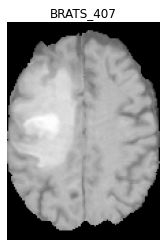

In [9]:
def class_to_str(idx):
    return "healthy" if idx == 0 else "tumour"


# get random file and transform
while True:
    rand_file = np.random.choice(data_dicts)
    data = transforms(rand_file)
    im_t = data["image"][None].to(device)
    im = np.mean(im_t[0].cpu().numpy(), axis=0, keepdims=True)
    fname = os.path.basename(data["image_meta_dict"]["filename_or_obj"])[:-7]
    gt = data["label"][1]
    gt_str = class_to_str(gt)
    if gt_str == "tumour":
        break

# infer
logits = model(im_t)[0]
logits = torch.nn.functional.softmax(logits, dim=0).detach().cpu().numpy()
pred = logits.argmax(0).item()
pred_str = class_to_str(pred)
prob = logits[pred].item() * 100  # percentage
print(f"Logits: {logits}")
print(f"Actual class: {gt_str}. Pred class: {pred_str}, prob {prob:.3f}%.")

# visualise
plt.figure(facecolor="white")
plt.imshow(im[0], cmap="gray")
plt.title(f"{fname}")
_ = plt.axis("off")

## 6. Saliency

In [10]:
def compare_saliency(img, saliency_map, title, fig=None, ax=None):
    if isinstance(saliency_map, torch.Tensor):
        saliency_map = saliency_map.detach().cpu().numpy()
    if fig is None:
        fig, ax = plt.subplots(1, 1, facecolor='white')
    ax.imshow(img[0], cmap="gray")
    imshow2 = ax.imshow(
        saliency_map, cmap="jet", alpha=(img[0] > 0).astype(np.float32) * 0.5
    )
    fig.colorbar(imshow2, ax=ax)
    ax.axis("off")
    ax.set_title(title)

## Occlusion sensitivity

With occlusion sensitivity we iteratively block off part of the image and then we record the changes in certainty of the inferred class. This means that for instances where the network correctly infers the image type, we expect the certainty to drop as we occlude important parts of the image. Hence, for correct inference, blue parts of the image imply importance.

The parameter `mask_size` is used to determine the size of the square used to occlude the input image. If the mask is smaller than the features you are looking for, then certainty might not drop by much, as most of the original object is present. Conversely, if the masked area is too large, it might be hard to pinpoint where in the occluded area the important part is. It's a bit of a dark art to choosing the optimal mask size, but remember that your decision will introduce a bias, since you are telling the method the size of the features you expect the network to be picking up, not necessarily the features that the network is **actually** picking up.

The parameter `stride` determines how far the occluded area shifts by for each occlusion. Smaller gives higher resolution images at the expense of computation speed. Setting the stride too large may skip over important features.

Feel free to play with `mask_size` and see if has any affect on the output image.

Computing occlusion sensitivity: 100%|██████████| 280/280 [00:00<00:00, 293.52it/s]


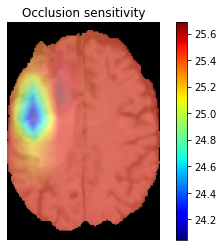

In [11]:
stride = 16
batch_size = 30
mask_size = 10

occ_sens = OcclusionSensitivity(model, mask_size=mask_size, n_batch=batch_size, stride=stride)
out_occ_sens, _ = occ_sens(im_t)
out_occ_sens = out_occ_sens[0, ..., pred].cpu().numpy()
# average across channels
out_occ_sens = np.mean(out_occ_sens, 0)

compare_saliency(im, out_occ_sens, "Occlusion sensitivity")

## GradCAM
Next, we'll have a look at GradCAM. Specifically, we'll look at a variation called GradCAM++.

The user chooses a layer of the network that interests them and the gradient is calculated at this point. The chosen layer is typically towards the bottom of the network, as all the features have hopefully been extracted by this point. The images have been downsampled many times, and so the resulting images are linearly upsampled to match the size of the input image. As with occlusion sensitivity, blue parts of the image imply importance in the decision making process.

Using a layer towards the end should give the most information on the network (since they input will have travelled through more layers), but will also give lower spatial resolution, due to the downwards convolutions. You can play around with this.

To get the names of the layers of your network, the following should work:

```python
for name, _ in model.named_modules(): print(name)
```

And the output might look like:

```
features
features.conv0
features.norm0
features.relu0
features.pool0
features.denseblock1
...
features.denseblock4.denselayer16.layers.conv2
features.norm5
class_layers
class_layers.relu
class_layers.pool
class_layers.flatten
class_layers.out
```

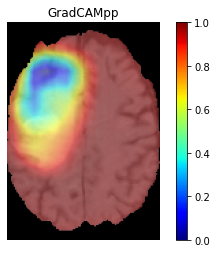

In [12]:
target_layer = "features.transition2.relu"
gradcampp = GradCAMpp(model, target_layers=target_layer)

# GradCAM
out_cam_pp = gradcampp(x=im_t, class_idx=pred)[0, 0]
compare_saliency(im, out_cam_pp, "GradCAMpp")

## SmoothGrad

### VanillaGrad

`VanillaGrad` computes the gradient of the class score function with respect to the input image. It is the basis for `SmoothGrad`, `GuidedBackpropGrad`, and `GuidedBackpropSmoothGrad`. For all of these methods, red areas imply importance in the decision making process.

`VanillaGrad` is omitted in this notebook to save space but the user can add it in if interested.

### SmoothGrad
 `SmoothGrad` repeatedly (default=25) adds noise to the input image and performs `VanillaGrad`. The results are then averaged.


Computing SmoothGrad: 100%|██████████| 25/25 [00:02<00:00, 10.47it/s]


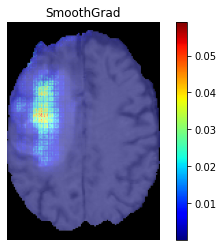

In [13]:
smooth_grad = SmoothGrad(model, n_samples=25, magnitude=True, stdev_spread=0.04)
out_smooth_grad = smooth_grad(im_t)[0].cpu().numpy()
# average across four input channels
out_smooth_grad = np.mean(out_smooth_grad, 0)
compare_saliency(im, out_smooth_grad, "SmoothGrad")

## GuidedBackPropGrad and GuidedBackpropSmoothGrad
`GuidedBackpropGrad` and `GuidedBackpropSmoothGrad` extend upon `VanillaGrad` and `SmoothGrad`, respectively. 

`GuidedBackPropGrad` computes the gradient of the target output with respect to the input, but gradients of `ReLU` functions are overridden so that only non-negative gradients are backpropagated.

`GuidedBackpropSmoothGrad` is to `GuidedBackPropGrad` as `SmoothGrad` is to `VanillaGrad`.

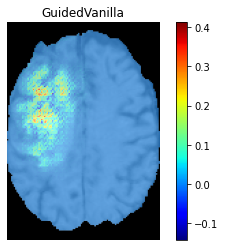

In [14]:
guided_vanilla = GuidedBackpropGrad(model)
out_guided_vanilla = guided_vanilla(im_t)[0].cpu().numpy()
# average across four input channels
out_guided_vanilla = np.mean(out_guided_vanilla, 0)
compare_saliency(im, out_guided_vanilla, "GuidedVanilla")

## GuidedBackPropSmoothGrad

Computing GuidedBackpropSmoothGrad: 100%|██████████| 25/25 [00:03<00:00,  6.71it/s]


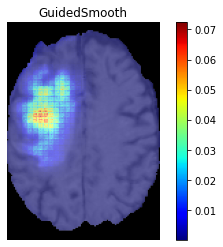

In [15]:
guided_smooth = GuidedBackpropSmoothGrad(model)
out_guided_smooth = guided_smooth(im_t)[0].cpu().numpy()
# average across four input channels
out_guided_smooth = np.mean(out_guided_smooth, 0)
compare_saliency(im, out_guided_smooth, "GuidedSmooth")

## Show all

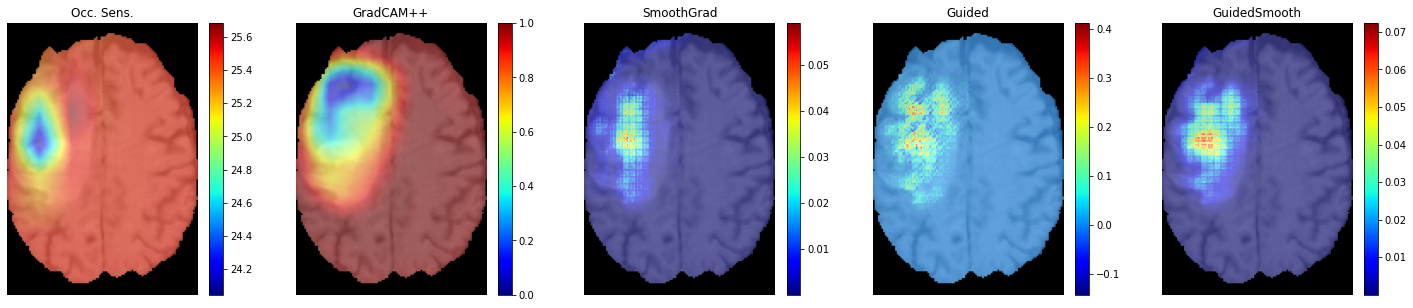

In [16]:
ims = [out_occ_sens, out_cam_pp, out_smooth_grad, out_guided_vanilla, out_guided_smooth]
titles = ["Occ. Sens.", "GradCAM++", "SmoothGrad", "Guided", "GuidedSmooth"]
fig, axes = plt.subplots(1, len(ims), facecolor='white', figsize=[len(ims) * 5, 5])
for _saliency, _title, _ax in zip(ims, titles, axes):
    compare_saliency(im, _saliency, _title, fig, _ax)